### Set up

In [ ]:
"""
This is a multi-label classification task.

Deep learning architecture is used here to address the task. 
In particular, an LSTM (Long Shot Term Memory) is implemented.

In prediction time, a vector of 6 elements is build to make inference, and
determine whether a comment is offensive or not
"""

In [94]:
import warnings
warnings.filterwarnings("ignore")
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

In [95]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation, Masking, Bidirectional, GlobalMaxPool1D
from keras.models import Sequential
from keras.optimizers import Adam
from tensorflow.keras.backend import clear_session
from keras import regularizers
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from keras.callbacks import EarlyStopping

# Download NLTK resources
import nltk
nltk.download('stopwords')
nltk.download('punkt')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [96]:
# import dataset and show the first rows
df = pd.read_csv('Filter_Toxic_Comments_dataset.csv')
df.head()

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,sum_injurious
0,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,0
1,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,0
2,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,0
3,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,0
4,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,0


### Preprocessing

In [97]:
# define X and y
X = df['comment_text']
y= df[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']].values

In [98]:
# Check if there are any null values in X
X.isnull().any()

False

In [99]:
# Check if there are any values in y that differ from 0 or 1
mask = np.logical_and(y != 0, y != 1)
if np.any(mask):
    print('There are values in y that differ from 0 or 1')
else:
    print('All values in y are either 0 or 1')

All values in y are either 0 or 1


In [100]:
"""
Although the Tokenizer() class would perform the same operation by setting the
parameter lower='True', we still need to perform the lower() method.
This is because we need to remove stopwords before the tokenization, and the
stopwords list is made of lower case words only. So, if we started by removing
the stopwords without applying the lower() method first, words like 'The' would
not be removed.
"""

# Text normalization
def normalize_text(input_text):
    # Convert text to lower case
    input_text = input_text.lower()
    # Remove punctuation
    input_text = re.sub(r'[^\w\s]', '', input_text)
    return input_text
    # Remove non-Latin characters
    input_text = re.sub(r'[^\x00-\x7F]+', '', input_text)

X = X.apply(normalize_text)

In [101]:
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [102]:
# Remove stopwords
stop_words = set(stopwords.words('english'))

def remove_stopwords(input_text):
    tokens = word_tokenize(input_text)  # Use NLTK's word_tokenize for tokenization
    filtered_tokens = [token for token in tokens if token not in stop_words]
    filtered_text = ' '.join(filtered_tokens)
    return filtered_text

X = X.apply(remove_stopwords)

In [103]:
# split the dataset into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25, random_state=42)

In [104]:
max_features=50000 # number of words we'll keep to train our model, according to their frequency

X_tokenizer = Tokenizer(num_words=max_features)
# fit the Tokenizer on training text data to create an index of all the words in the training data, sorted by frequency.
X_tokenizer.fit_on_texts(list(X_train))
# convert text into sequences of tokens (integers), using the indexing we've just created above.
X_train_seq = X_tokenizer.texts_to_sequences(X_train)
X_test_seq = X_tokenizer.texts_to_sequences(X_test)

In [105]:
"""
After the stopwords have been removed, we are left with a total number of words
equal to 208,815. Taking all of them would be computationally heavy, so we will
take only the most recurrent. This will lower the accuracy of the model (espacially
if the injurious comments are exceedingly "creative"), but will save us some time.
"""
vocabulary_size = len(X_tokenizer.word_index)+1
print(f'vocabulary_size: {vocabulary_size}')

vocabulary_size: 208815


In [106]:
# Find the maximum length for a sentence in the dataset
maxlen = len(max(X_train_seq, key=len))
print('Maximum sequence length:',maxlen)

Maximum sequence length: 1250


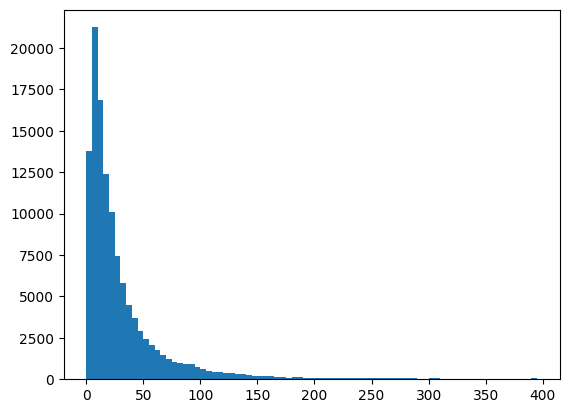

In [107]:
"""
Although the maximum sequence length is 1250, we will reduce it to 200 to shorten
the training time. Moreover, the plot below indicates that the majority of
comments are less than 100 words long, so we won't lose much information.

"""
# X axis: number of words in a sentence
# y axis: number of sentences within the range

# create a list containing the length of each comment in X_train
seq_length = [len(comment) for comment in X_train_seq]
# group the comments into ranges of 5, according to their length
plt.hist(seq_length, bins=np.arange(0,400,5))
plt.show()

In [108]:
maxlen = 200 # set the maximum length for a sentence

# this method pads the sequences to ensure that vectors are of equal length
X_train_pad = pad_sequences(X_train_seq, maxlen=maxlen, padding='pre')
# parameter padding='pre' is the default one, but here is specified for clarity
X_test_pad = pad_sequences(X_test_seq, maxlen=maxlen, padding='pre')

In [109]:
"""
Now that we've processed, tokenized and padded our text, let's turn it back to
text form, to see how it changed, and if we didn't lose too much information.
"""

X_train_texts = X_tokenizer.sequences_to_texts(X_train_seq)
X_train_texts

['added sign back see hovering block also made changes darker hat easily visible still want change colors set styles refers moved block coloring previously rainbow colors',
 'dont worry think fixed still looks cramped',
 'well seems problem wikipedia private property dictate version way better others say wikipedia standard layout tables look said think version would fine longer list looks awkward place simpler version one used cdu looks professional imho',
 'contents contents box appears 4 items header level 1 page case 4 comments eg random wikipedia message naturally deleted one 3 items longer appeared comment fix hope answer helps',
 'btw know article links site get live fatwa online',
 'listas hughes carol',
 '29 july 2015 utc hopelessly long winded see words restored blanked instead moaning suggest learn wiki basics like read edit history need second guess thousands user pages noone would think deleting give ideas two looked recently userpigsonthewing basically launch user page lot

### Model definition

In [110]:
clear_session()

model = Sequential()
model.add(Masking(mask_value=0.0, input_shape=(maxlen,))) # skip over padded values
model.add(Embedding(input_dim=max_features, output_dim=32))
model.add(LSTM(32, return_sequences=True, name='lstm_layer'))
model.add(GlobalMaxPool1D()) # reduces the dimensionality of the output from the LSTM layer
model.add(Dropout(0.1)) # prevents overfitting by randomly dropping out some of the units in the previous layer during training
model.add(Dense(24, activation='relu',
kernel_regularizer=regularizers.l2(0.01)))
model.add(Dropout(0.3))
model.add(Dense(6, activation='sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking (Masking)           (None, 200)               0         
                                                                 
 embedding (Embedding)       (None, 200, 32)           1600000   
                                                                 
 lstm_layer (LSTM)           (None, 200, 32)           8320      
                                                                 
 global_max_pooling1d (Glob  (None, 32)                0         
 alMaxPooling1D)                                                 
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense (Dense)               (None, 24)                792       
                                                        

In [111]:
model.compile(loss='binary_crossentropy',
                  optimizer=Adam(learning_rate=0.001),
                  metrics=['accuracy'])

In [112]:
"""
Since the accuracy appears to be very high in any epochs, I decided to base the
early_stopping on 'val_loss' instead of 'val_accuracy' to prevent overfitting,
as an increasing loss indicates that the model is becoming less effective at
generalizing to new data.

The loss function calculates the difference between the predicted output and the
actual output, and returns a value that represents the error of the model.
"""

# Define Early Stopping
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3, # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True, # Restore model weights from the epoch with the best value of the monitored quantity
    verbose=1
)

In [113]:
# Train the model with Early Stopping
history = model.fit(
    X_train_pad, y_train,
    batch_size=32,
    epochs=100, # set a high number, so early stopping can stop the training when needed
    validation_split=0.2,
    callbacks=[early_stopping]
)

Epoch 1/100
2992/2992 [==============================] - 107s 35ms/step - loss: 0.1547 - accuracy: 0.8844 - val_loss: 0.0826 - val_accuracy: 0.9943
Epoch 2/100
2992/2992 [==============================] - 45s 15ms/step - loss: 0.0673 - accuracy: 0.9941 - val_loss: 0.0583 - val_accuracy: 0.9943
Epoch 3/100
2992/2992 [==============================] - 46s 15ms/step - loss: 0.0540 - accuracy: 0.9943 - val_loss: 0.0573 - val_accuracy: 0.9943
Epoch 4/100
2992/2992 [==============================] - 42s 14ms/step - loss: 0.0487 - accuracy: 0.9943 - val_loss: 0.0568 - val_accuracy: 0.9943
Epoch 5/100
2992/2992 [==============================] - 40s 13ms/step - loss: 0.0452 - accuracy: 0.9943 - val_loss: 0.0589 - val_accuracy: 0.9943
Epoch 6/100
2992/2992 [==============================] - 40s 13ms/step - loss: 0.0423 - accuracy: 0.9943 - val_loss: 0.0680 - val_accuracy: 0.9943
Epoch 7/100
2992/2992 [==============================] - 39s 13ms/step - loss: 0.0402 - accuracy: 0.9942 - val_loss: 

### Model evaluation

In [114]:
# Evaluate the trained model on unseen data
score = model.evaluate(X_test_pad, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.05623846873641014
Test accuracy: 0.9938836097717285


In [115]:
"""
The results seem promising, even if the val_accuracy always showing the same value
looks strange. I've tried many adjustments to the model, adding regularizers and
dorpout layers with different values, but only the accuracy changed. For example,
I first set bith the Dropout layers = 0.1, with poor results in the first epochs,
getting better while proceeding with the training. The val_accuracy, on the other
hand, was always around the same value, i.e. 0.9943.
"""

"\nThe results seem promising, even if the val_accuracy always showing the same value \nlooks strange. I've tried many adjustments to the model, adding regularizers and \ndorpout layers with different values, but only the accuracy changed. For example, \nI first set bith the Dropout layers = 0.1, with poor results in the first epochs,\ngetting better while proceeding with the training. The val_accuracy, on the other \nhand, was always around the same value, i.e. 0.9943.\n"

In [116]:
# Evaluate predictions on the test set
predictions = model.predict(X_test_pad)

# convert predictions to binary values (0 or 1)
binary_predictions = (predictions > 0.5).astype(int)

# Create a DataFrame to store results
result_df = pd.DataFrame(binary_predictions, columns=['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate'])

# Add the 'sum_injurious' column
result_df['sum_injurious'] = result_df.sum(axis=1)

# Concatenate the original comments from the test set
result_df['comment_text'] = X_test.values

# Export the results to an Excel file
result_df.to_excel('prediction_results.xlsx', index=False)


1247/1247 [==============================] - 7s 5ms/step


In [117]:
result_df.head()

,toxic,severe_toxic,obscene,threat,insult,identity_hate,sum_injurious,comment_text
0,0,0,0,0,0,0,0,geez forgetful weve already discussed marx ana...
1,0,0,0,0,0,0,0,carioca rfa thanks support request adminship f...
2,0,0,0,0,0,0,0,birthday worries enjoy ur daytalke
3,0,0,0,0,0,0,0,pseudoscience category im assuming article pse...
4,0,0,0,0,0,0,0,phrase exists would provided search engine eve...


In [118]:
# Export the results to an Excel file
result_df.to_excel('prediction_results.xlsx', index=False)

In [119]:
"""
Looking at the Excel file, it look clear that the model is not able to recognize
'severe_toxic' (which is actually a bit confusing, because there is the label
'toxic' already), 'threat', and 'identity_hate'. All these labels only have 0s.

Let's try then to write a sentence that clearly represent a threat (without
including other types of insults), and then one

"""

"\nLooking at the Excel file, it look clear that the model is not able to recognize\n'severe_toxic' (which is actually a bit confusing, because there is the label \n'toxic' already), 'threat', and 'identity_hate'. All these labels only have 0s.\n\nLet's try then to write a sentence that clearly represent a threat (without \nincluding other types of insults), and then one \n\n"

In [120]:
def classify_comment(comment_text):
    # Vectorize the comment text
    comment_vector = X_tokenizer.texts_to_sequences([comment_text])
    comment_vector = pad_sequences(comment_vector, maxlen=maxlen, padding='pre')

    # Make predictions for the given comment vector
    comment_predictions = model.predict(comment_vector.reshape(1, -1))

    # Convert predictions to binary values (0 or 1)
    binary_predictions = (comment_predictions > 0.5).astype(int)[0]

    # Create a dataframe-like vector with labels
    label_vector = pd.DataFrame(binary_predictions.reshape(1, -1),
                                columns=['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate'])

    return label_vector


In [121]:
# Test 1: dark threat
comment_text = "I will kill you and your family, cut you in pieces, and then eat you for dinner."
label_vector = classify_comment(comment_text)
print(label_vector)


1/1 [==============================] - 0s 24ms/step
   toxic  severe_toxic  obscene  threat  insult  identity_hate
0      0             0        0       0       0              0


In [122]:
"""
Strangely, the previous comment, which is much darker, has been classified with
no positive predictions, while the one below has been classifies as 'toxic',
even if it's clearly a threat.
"""
# Test 2: threat
comment_text = "I will kill you and your family."
label_vector = classify_comment(comment_text)
print(label_vector)

1/1 [==============================] - 0s 23ms/step
   toxic  severe_toxic  obscene  threat  insult  identity_hate
0      1             0        0       0       0              0


In [123]:
"""
As we said, the model is weak in the task of identifying identity_hate comments,
probably because in the sentence there are no clear bad words, even if the content
is still very offensive.
"""

comment_text = "How can you be a man and a woman at the same time?! Gross! Transgender...bleah. I have shivers right now..."
label_vector = classify_comment(comment_text)
print(label_vector)

1/1 [==============================] - 0s 22ms/step
   toxic  severe_toxic  obscene  threat  insult  identity_hate
0      0             0        0       0       0              0
